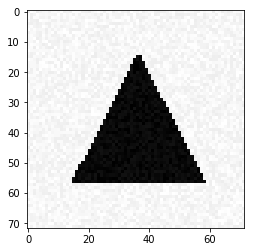

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# 3 Simple Classification

In [2]:
from keras.utils import np_utils

# dataset creation
[X_train, Y_train] = generate_dataset_classification(300, 20)

Y_train = np_utils.to_categorical(Y_train, 3)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [3]:
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.optimizers import SGD

n, input_size = X_train.shape

neurons_1 = 3

model_sgd = Sequential([
  Dense(neurons_1, input_shape=(input_size,)),
  Activation('softmax')])

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)

model_sgd.compile(loss='categorical_crossentropy', optimizer=sgd)

model_sgd.fit(X_train, Y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 8.0313
Epoch 2/100
300/300 [==============================] - 0s 136us/step - loss: 10.7991
Epoch 3/100
300/300 [==============================] - 0s 131us/step - loss: 10.7991
Epoch 4/100
300/300 [==============================] - 0s 128us/step - loss: 10.7991
Epoch 5/100
300/300 [==============================] - 0s 140us/step - loss: 10.7991
Epoch 6/100
300/300 [==============================] - 0s 121us/step - loss: 10.7991
Epoch 7/100
300/300 [==============================] - 0s 138us/step - loss: 10.7991
Epoch 8/100
300/300 [==============================] - 0s 124us/step - loss: 10.7991
Epoch 9/100
300/300 [==============================] - 0s 128us/step - loss: 10.7991
Epoch 10/100
300/300 [==============================] - 0s 137us/step - loss: 10.7991
Epoch 11/100
300/300 [==============================] - 0s 149us/step - loss: 10.7991
Epoch 12/100
300/300 [==============================] - 0s 135us/s

300/300 [==============================] - 0s 147us/step - loss: 10.7991
Epoch 97/100
300/300 [==============================] - 0s 144us/step - loss: 10.7991
Epoch 98/100
300/300 [==============================] - 0s 142us/step - loss: 10.7991
Epoch 99/100
300/300 [==============================] - 0s 144us/step - loss: 10.7991
Epoch 100/100
300/300 [==============================] - 0s 149us/step - loss: 10.7991


In [9]:
model_adam = Sequential([
  Dense(neurons_1, input_shape=(input_size,)),
  Activation('softmax'),])

model_adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_adam.fit(X_train, Y_train, batch_size=32, epochs=40, verbose=1)

Epoch 1/40
300/300 [==============================] - 0s 852us/step - loss: 2.0262 - acc: 0.3300
Epoch 2/40
300/300 [==============================] - 0s 151us/step - loss: 0.9372 - acc: 0.6167
Epoch 3/40
300/300 [==============================] - 0s 143us/step - loss: 0.6345 - acc: 0.6800
Epoch 4/40
300/300 [==============================] - 0s 138us/step - loss: 0.4638 - acc: 0.8700
Epoch 5/40
300/300 [==============================] - 0s 136us/step - loss: 0.3375 - acc: 0.9233
Epoch 6/40
300/300 [==============================] - 0s 148us/step - loss: 0.3097 - acc: 0.8933
Epoch 7/40
300/300 [==============================] - 0s 140us/step - loss: 0.3187 - acc: 0.8700
Epoch 8/40
300/300 [==============================] - 0s 146us/step - loss: 0.2166 - acc: 0.9633
Epoch 9/40
300/300 [==============================] - 0s 154us/step - loss: 0.1935 - acc: 0.9767
Epoch 10/40
300/300 [==============================] - 0s 133us/step - loss: 0.1755 - acc: 0.9767
Epoch 11/40
300/300 [========

In [10]:
# Testing
X_test_1 = generate_a_rectangle()
X_test_1 = X_test_1.reshape(1, X_test_1.shape[0])
print(model_sgd.predict(X_test_1))
print(model_adam.predict(X_test_1))

X_test_2 = generate_a_disk()
X_test_2 = X_test_2.reshape(1, X_test_2.shape[0])
print(model_sgd.predict(X_test_2))
print(model_adam.predict(X_test_2))

[[1. 0. 0.]]
[[1. 0. 0.]]
[[1. 0. 0.]]
[[0. 1. 0.]]


# Comment 1

Clearly with the Adam optimizer the network works much better with an accuracy of 1. From testing we see that the model that uses sgd has troubles to classify correctly images.

# 4 Visualization of the Solution

Text(0.5,1,'Weights for the triangle')

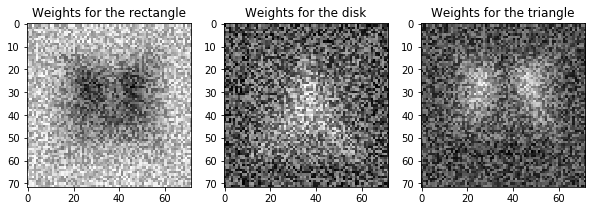

In [11]:
plt.subplots(1,3, figsize=(10,10))

weights_sgd = model_sgd.get_weights()
weights_sgd_rectangle = weights_sgd[0][:,0]
plt.subplot(131)
plt.imshow(weights_sgd_rectangle.reshape(72,72), cmap='gray')
plt.title("Weights for the rectangle")

weights_sgd_disk = weights_sgd[0][:,1]
plt.subplot(132)
plt.imshow(weights_sgd_disk.reshape(72,72), cmap='gray')
plt.title("Weights for the disk")

weights_sgd_triangle = weights_sgd[0][:,2]
plt.subplot(133)
plt.imshow(weights_sgd_triangle.reshape(72,72), cmap='gray')
plt.title("Weights for the triangle")

Text(0.5,1,'Weights for the triangle')

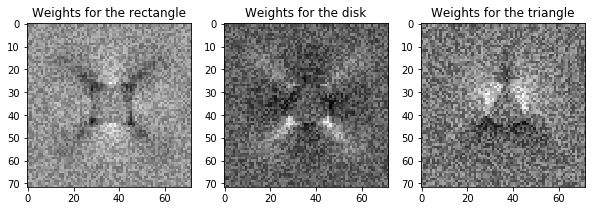

In [12]:
plt.subplots(1,3, figsize=(10,10))

weights_adam = model_adam.get_weights()
weights_adam_rectangle = weights_adam[0][:,0]
plt.subplot(131)
plt.imshow(weights_adam_rectangle.reshape(72,72), cmap='gray')
plt.title("Weights for the rectangle")

weights_adam_disk = weights_adam[0][:,1]
plt.subplot(132)
plt.imshow(weights_adam_disk.reshape(72,72), cmap='gray')
plt.title("Weights for the disk")

weights_adam_triangle = weights_adam[0][:,2]
plt.subplot(133)
plt.imshow(weights_adam_triangle.reshape(72,72), cmap='gray')
plt.title("Weights for the triangle")

# 5 A More Difficult Classification Problem

In [8]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Y_train = np_utils.to_categorical(Y_train, 3)

model = Sequential([
  Dense(neurons_1, input_shape=(input_size,)),
  Activation('relu'),
  Dense(neurons_2),
  Activation('softmax')])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose=1)

[X_test, Y_test] = generate_test_set_classification()

model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 1.2039 - acc: 0.3200
Epoch 2/100
300/300 [==============================] - 0s 142us/step - loss: 1.0987 - acc: 0.3133
Epoch 3/100
300/300 [==============================] - 0s 142us/step - loss: 1.0987 - acc: 0.3133
Epoch 4/100
300/300 [==============================] - 0s 141us/step - loss: 1.0987 - acc: 0.3333
Epoch 5/100
300/300 [==============================] - 0s 143us/step - loss: 1.0986 - acc: 0.3467
Epoch 6/100
300/300 [==============================] - 0s 142us/step - loss: 1.0985 - acc: 0.3467
Epoch 7/100
300/300 [==============================] - 0s 143us/step - loss: 1.0985 - acc: 0.3467
Epoch 8/100
300/300 [==============================] - 0s 157us/step - loss: 1.0985 - acc: 0.3467
Epoch 9/100
300/300 [==============================] - 0s 144us/step - loss: 1.0984 - acc: 0.3

[1.0991438833872478, 0.3299999996026357]

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten 
from keras.layers import Dense 

[X_train, Y_train] = generate_dataset_classification(600, 20, True)

Y_train = np_utils.to_categorical(Y_train, 3)

r = int(np.sqrt(X_train.shape[1]))

X_train = X_train.reshape(X_train.shape[0], r, r, 1)

model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(r, r, 1)))

model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(32, (5, 5), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten()) 

model.add(Dense(3, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1)

[X_test, Y_test] = generate_test_set_classification()

X_test = X_test.reshape(X_test.shape[0], r, r, 1)

model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
Epoch 1/15
600/600 [==============================] - 4s 7ms/step - loss: 1.0333 - acc: 0.4900
Epoch 2/15
600/600 [==============================] - 4s 7ms/step - loss: 0.8391 - acc: 0.6433
Epoch 3/15
600/600 [==============================] - 4s 6ms/step - loss: 0.6957 - acc: 0.7017
Epoch 4/15
600/600 [==============================] - 4s 6ms/step - loss: 0.6156 - acc: 0.7567
Epoch 5/15
600/600 [==============================] - 4s 7ms/step - loss: 0.5296 - acc: 0.8000
Epoch 6/15
600/600 [==============================] - 5s 8ms/step - loss: 0.4467 - acc: 0.8350
Epoch 7/15
600/600 [==============================] - 5s 8ms/step - loss: 0.3595 - acc: 0.8817
Epoch 8/15
600/600 [==============================] - 5s 8ms/step - loss: 0.2884 - acc: 0.9

[0.26196873585383096, 0.9099999992052714]

# Comment 2

A simple feedforward neural network doesn't give good results on this task. A CNN is by far a better option.

# 6 A regression problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


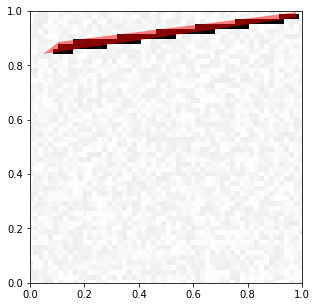

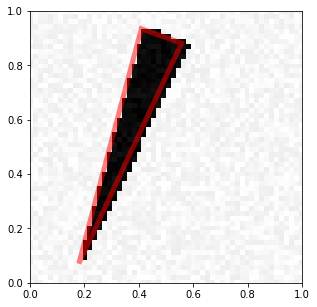

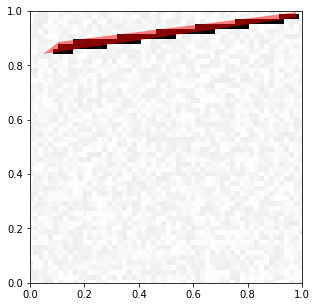

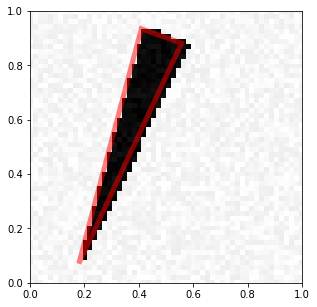

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [99]:
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# Training dataset
[X_train, Y_train] = generate_dataset_regression(300, 20)

visualize_prediction(X_train[0], Y_train[0])

visualize_prediction(X_train[1], Y_train[1])

Y_train_sort = np.zeros((Y_train.shape[0],Y_train.shape[1]))

# Sorting the vertices in Y_train
for i in range(Y_train.shape[0]):
    x = Y_train[i,::2]
    y = Y_train[i,1::2]
    x_o = [x for x,y in sorted(zip(x,y), reverse=False)]
    y_o = [y for x,y in sorted(zip(x,y), reverse=False)]
    Y_train_sort[i,:] = [x_o[0], y_o[0],x_o[1], y_o[1],x_o[2], y_o[2]]
    
visualize_prediction(X_train[0], Y_train[0])

visualize_prediction(X_train[1], Y_train[1])

# Test dataset
[X_test, Y_test] = generate_test_set_regression()

Y_test_sort = np.zeros((Y_test.shape[0],Y_test.shape[1]))

# Sorting the vertices in Y_test
for i in range(Y_test.shape[0]):
    x = Y_test[i,::2]
    y = Y_test[i,1::2]
    x_o = [x for x,y in sorted(zip(x,y), reverse=False)]
    y_o = [y for x,y in sorted(zip(x,y), reverse=False)]
    Y_test_sort[i,:] = [x_o[0], y_o[0],x_o[1], y_o[1],x_o[2], y_o[2]]

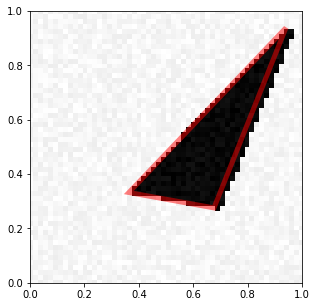

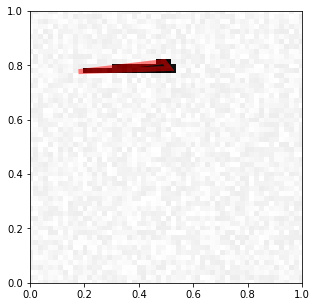

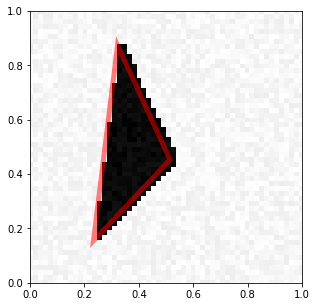

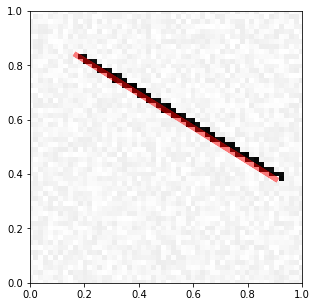

In [100]:
# Visualize some examples
visualize_prediction(X_test[0], Y_test_sort[0])
visualize_prediction(X_test[1], Y_test_sort[1])
visualize_prediction(X_test[2], Y_test_sort[2])
visualize_prediction(X_test[3], Y_test_sort[3])

Epoch 1/10
300/300 [==============================] - 2s 6ms/step - loss: 0.9278
Epoch 2/10
300/300 [==============================] - 0s 195us/step - loss: 0.3333
Epoch 3/10
300/300 [==============================] - 0s 198us/step - loss: 0.3283
Epoch 4/10
300/300 [==============================] - 0s 191us/step - loss: 0.3192
Epoch 5/10
300/300 [==============================] - 0s 199us/step - loss: 0.3097
Epoch 6/10
300/300 [==============================] - 0s 192us/step - loss: 0.3002
Epoch 7/10
300/300 [==============================] - 0s 190us/step - loss: 0.2909
Epoch 8/10
300/300 [==============================] - 0s 194us/step - loss: 0.2818
Epoch 9/10
300/300 [==============================] - 0s 193us/step - loss: 0.2729
Epoch 10/10
300/300 [==============================] - 1s 2ms/step


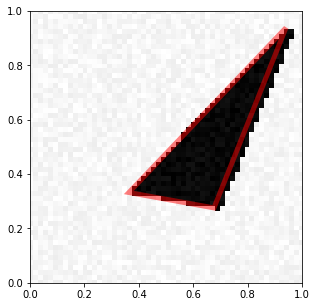

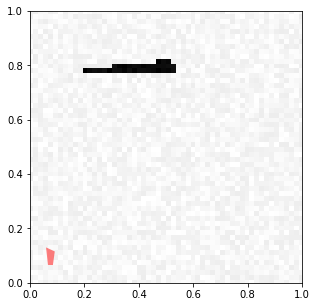

In [101]:
model = Sequential([
  Dense(20, input_shape=(X_train.shape[1],)),
  Activation('relu'),
  Dense(15),
  Activation("relu"),
  Dense(6),
  Activation('linear')])

model.compile(loss='mean_squared_error', optimizer="adam")

model.fit(X_train, Y_train_sort, batch_size=32, epochs=10, verbose=1)

model.evaluate(X_test, Y_test_sort)

visualize_prediction(X_test[0], Y_test_sort[0])

visualize_prediction(X_test[1], model.predict(X_test)[1,:])

# Comment

A simple feedforward model is not effective in this kind of task.

In [102]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten 
from keras.layers import Dense 
from keras.layers import Dropout

r = 72

X_train = X_train.reshape(X_train.shape[0], r, r, 1)

model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(r, r, 1)))

model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.22))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(Dropout(0.25))

model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten()) 

model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.2))

model.add(Dense(36, activation='relu')) 
model.add(Dropout(0.2))

model.add(Dense(6, activation='relu')) 

print(model.summary())

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.fit(X_train, Y_train_sort, batch_size=32, epochs=100, verbose=1)

X_test = X_test.reshape(X_test.shape[0], r, r, 1)

model.evaluate(X_test, Y_test_sort)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 30, 30, 32)        12832     
_________________________________________________________________
dropout_70 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 11, 11, 64)        51264     
__________

Epoch 54/100
300/300 [==============================] - 3s 10ms/step - loss: 0.0200 - mean_absolute_error: 0.1092
Epoch 55/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0193 - mean_absolute_error: 0.1074
Epoch 56/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0183 - mean_absolute_error: 0.1056
Epoch 57/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0179 - mean_absolute_error: 0.1042
Epoch 58/100
300/300 [==============================] - 3s 10ms/step - loss: 0.0197 - mean_absolute_error: 0.1072
Epoch 59/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0183 - mean_absolute_error: 0.1059
Epoch 60/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0163 - mean_absolute_error: 0.0980
Epoch 61/100
300/300 [==============================] - 3s 10ms/step - loss: 0.0183 - mean_absolute_error: 0.1056
Epoch 62/100
300/300 [==============================] - 3s 9ms/step - loss: 0.0170 - mean_abs

[0.01931828697522481, 0.10373109608888625]

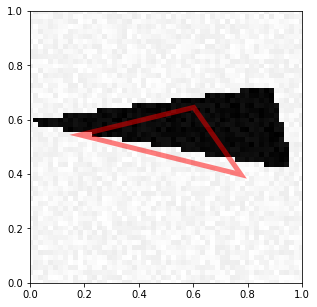

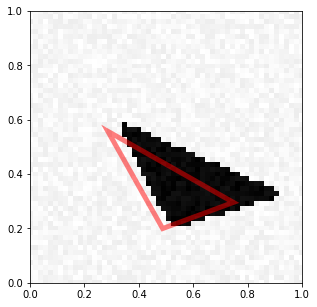

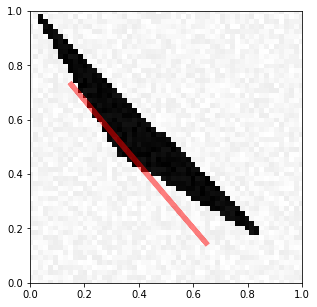

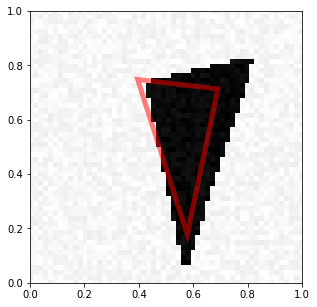

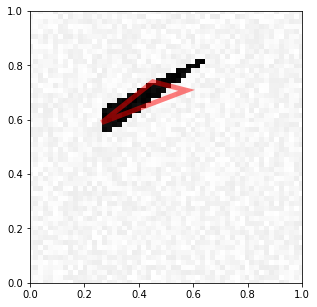

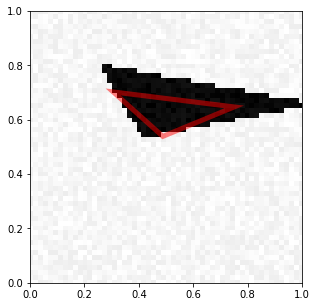

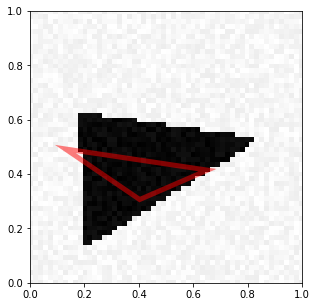

In [103]:
X_test_prediction = model.predict(X_test)

visualize_prediction(X_test[30], X_test_prediction[30])
visualize_prediction(X_test[31], X_test_prediction[31])
visualize_prediction(X_test[32], X_test_prediction[32])
visualize_prediction(X_test[33], X_test_prediction[33])
visualize_prediction(X_test[34], X_test_prediction[34])
visualize_prediction(X_test[35], X_test_prediction[35])
visualize_prediction(X_test[36], X_test_prediction[36])

# Comment

With a CNN with many layers we get good results. We first use convolutional neural network to extract the features of the image and the flatten to well predict the 6 coordinates.

I ordered the vertex in order to give consistency to the data.

# 7 Image denoising

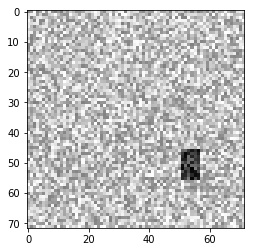

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import np_utils

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_1(figsize, U, V, noise):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_1(noise, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)]


def generate_a_disk_1(noise, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)


def generate_a_triangle_1(noise, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    imdata_1 = generate_a_drawing(figsize, U, V, 0)
    
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]], [imdata_1, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im, im_1 = generate_a_rectangle_1(250, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#plt.imshow(im_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im, im_1 = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#plt.imshow(im_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v], [im_1, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#plt.imshow(im_1.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification_1(nb_samples, noise=250, free_location=False):
    noise=250
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    X_1 = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], X_1[i] = generate_a_rectangle_1(noise, free_location)
        elif category == 1: 
            X[i], X_1[i] = generate_a_disk_1(noise, free_location)
        else:
            [X[i], V],[X_1[i], V]  = generate_a_triangle_1(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, X_1, Y]

def generate_test_set_classification_1():
    np.random.seed(42)
    [X_test, X_test_1, Y_test] = generate_dataset_classification_1(300, 250, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, X_test_1, Y_test]

def generate_dataset_regression_1(nb_samples, noise=100):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction_1(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression_1():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [105]:
[X_train, Y_train, a] = generate_dataset_classification_1(300, 20)

[X_test, Y_test, a] = generate_test_set_classification_1()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


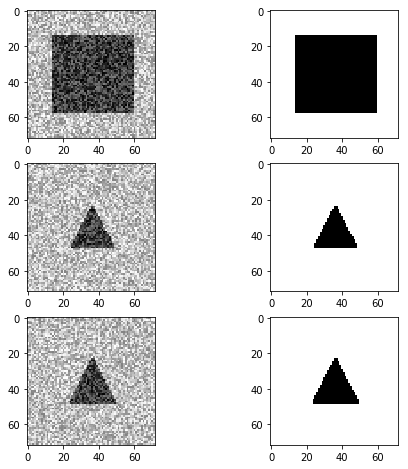

In [106]:
# Visulazing examples
fig, ax = plt.subplots(3,2, figsize=(8,8))
ax[0,0].imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[0,1].imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,0].imshow(X_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,1].imshow(Y_train[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,0].imshow(X_train[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,1].imshow(Y_train[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [131]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten 
from keras.layers import UpSampling2D
from keras.layers import Conv2DTranspose

r = 72

X_train = X_train.reshape(X_train.shape[0], r, r, 1)

Y_train = Y_train.reshape(Y_train.shape[0], r, r, 1)

model = Sequential()

model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(r, r, 1), padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.2))

model.add(Conv2D(32, (5, 5), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))

model.add(UpSampling2D((2, 2)))

model.add(Conv2DTranspose(32, (5, 5), strides=(1,1), activation='relu'))
model.add(Dropout(0.2))

model.add(UpSampling2D((2, 2)))

model.add(Conv2D(16, (4, 4), activation='relu', padding='same'))

model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))

model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

print(model.summary())

model.compile(loss="mean_squared_error", optimizer='adam')

model.fit(X_train, Y_train/255, batch_size=32, epochs=100, verbose=1)

X_test = X_test.reshape(X_test.shape[0], r, r, 1)

Y_test = Y_test.reshape(Y_test.shape[0], r, r, 1)

model.evaluate(X_test, Y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
dropout_104 (Dropout)        (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 32, 32, 32)        12832     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 16, 16, 64)        51264     
__________

59076.08078125

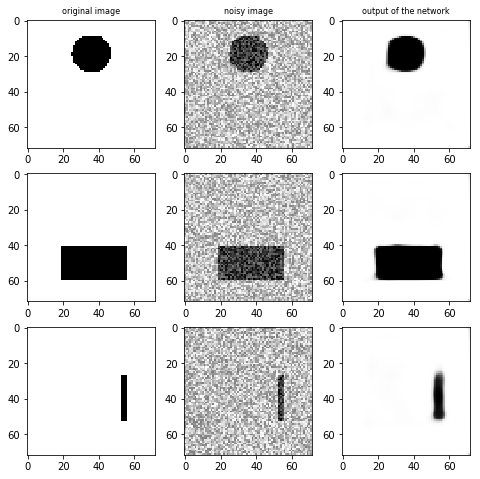

In [132]:
# Visualizing the predictions

X_test_prediction = model.predict(X_test)

fig, ax = plt.subplots(3,3, figsize=(8,8))
ax[0,0].set_title('original image',size=8)
ax[0,1].set_title('noisy image',size=8)
ax[0,2].set_title('output of the network',size=8)

ax[0,0].imshow(Y_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[0,1].imshow(X_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[0,2].imshow(X_test_prediction[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

ax[1,0].imshow(Y_test[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,1].imshow(X_test[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[1,2].imshow(X_test_prediction[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

ax[2,0].imshow(Y_test[4].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,1].imshow(X_test[4].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
ax[2,2].imshow(X_test_prediction[4].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# Comment

We implement a U-net that is the state of the art for this kind of task. The results are really impressive.